In [1]:
%reset -f

In [2]:
import lmfit
import matplotlib.pyplot as plt
import pystan
import emcee
from scipy.optimize import curve_fit
from lmfit import Model
import matplotlib
import numpy as np
import corner
plt.rcParams['figure.figsize'] = [12, 8]

The functions below will only help us reconstruct the images from pystan sampling/fitting results

In [3]:
def kernel(a, b,l):
    sqd=np.subtract.outer(a,b)**2
    return np.exp(-0.5*sqd/(l*l))

def get_GP_mean(tp,P,t,l):
    K=kernel(tp,tp,l);       #NPxNP
    Ks=kernel(tp,t,l);       #NPxN
    L=np.linalg.cholesky(K)# + 1e-15*np.eye(NP)); #NPxNP
    Lk=np.linalg.solve(L,Ks);      #NPxN
    z=np.linalg.solve(L,P);        #NP
    m=np.dot(Lk.T,z)   # ((Lk)')*z;// N
    return m;

We now work on a particular system in the ztf-1a data. The system no is 37755722. Below we plot the light curve in each band (red, green and indigo).

../read_data/ztf-1a/ztf-1a_stackedflux_sysn37755722_band_ztfr
../read_data/ztf-1a/ztf-1a_stackedflux_sysn37755722_band_ztfg
../read_data/ztf-1a/ztf-1a_stackedflux_sysn37755722_band_ztfi


<ErrorbarContainer object of 3 artists>

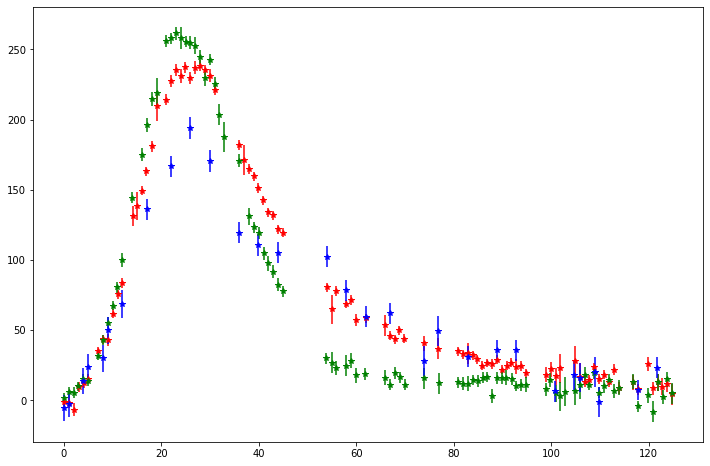

In [4]:
sysn=37755722
inp_path='../read_data/ztf-1a/'
bands=['ztfr','ztfg','ztfi']
fileN='ztf-1a_stackedflux_sysn%s_band_'%(sysn)

fileNr=inp_path+fileN+bands[0];print(fileNr)
fileNg=inp_path+fileN+bands[1];print(fileNg)
fileNi=inp_path+fileN+bands[2];print(fileNi)

tr,fr,sigfr=np.loadtxt(fileNr,usecols=[0,1,2], unpack=True)
tg,fg,sigfg=np.loadtxt(fileNg,usecols=[0,1,2], unpack=True)
ti,fi,sigfi=np.loadtxt(fileNi,usecols=[0,1,2], unpack=True)

t_mins=np.array([np.amin(tr), np.amin(tg), np.amin(ti)])
t_maxs=np.array([np.amax(tr), np.amax(tg), np.amax(ti)])
t_min=np.amin(t_mins)-1e-5; t_max=np.amax(t_maxs)+1e-5;

# we substract a fixed time, it should not have any effect on the pystan results
tr=tr-t_min; tg=tg-t_min; ti=ti-t_min; 

t_max=t_max-t_min; t_min=0.0;

c=['r','g','b']
plt.rcParams['figure.figsize'] = [12, 8]
plt.errorbar(tr,fr,yerr=sigfr,fmt='%s*'%(c[0]))
plt.errorbar(tg,fg,yerr=sigfg,fmt='%s*'%(c[1]))
plt.errorbar(ti,fi,yerr=sigfi,fmt='%s*'%(c[2]))


In [5]:
print("printing the flux in r-band",fr)

printing the flux in r-band [ -0.97790681  -1.755974    -6.70295482   9.35146621  12.30849245
  15.06216529  35.38286588  43.40742435  43.06776885  61.67379283
  75.57109325  83.60098155 130.96195702 138.48389585 149.33013545
 163.03813891 180.84302003 209.54030217 214.09825741 227.41243727
 235.47546124 231.14897106 237.15894005 229.45005612 237.03895547
 238.42055122 235.05053136 231.35490494 221.05126447 181.90796176
 171.10039066 164.91247503 159.55433482 151.37925032 142.43967709
 133.80443475 131.78109337 121.717213   119.4244231   80.50031272
  64.70467935  77.88337885  68.61948275  71.33134264  57.47652497
  58.31225392  53.48604495  46.02582541  43.48028737  49.75694196
  43.77255058  40.65070991  36.61897843  34.83596773  32.69868183
  33.36454859  31.8961277   29.11553468  24.64784449  26.5903363
  25.97430818  29.00498373  21.88986607  24.65276334  26.79131287
  23.87775524  24.41018543  19.12311755  18.22775526  22.04945905
  16.97002158  22.79130062  27.897484    16.42930

Why first few data points on r-band have negative flux??

Details of images of the system: sysno==37755722

In [6]:
import pandas as pd
datapath="/home/users/satadru/lensed_supernovae/data"
fin=datapath+'/ztf-1a.h5'
dfI=pd.read_hdf(fin, 'image')
print(dfI[dfI['sysno']==sysn]);
mus=dfI[dfI['sysno']==sysn]['mu']; dts=dfI[dfI['sysno']==sysn]['td']
mu_expec=np.abs(mus[0]/mus[1]); dt_expec=dts[1]-dts[0]
print("Expected: mu=",mu_expec, "dt=",dt_expec)

INFO:numexpr.utils:Note: NumExpr detected 28 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


         td         x         y        mu     sysno  imno
0  0.000000 -1.085469 -0.351792  1.625969  37755722     0
1  6.036739  0.226822 -0.012941 -0.903586  37755722     1
Expected: mu= 1.7994609012648153 dt= 6.036739147275044


We see that we have 2 images with a time delay of 6.036739 days. I am not sure what negative aplification means here (in the catalogue they said negative amplification means opposite "parity"!). Anyway, disregarding this negative sign we expect $\mu=1.625969/0.903586 \sim 1.8$ and $dt \sim 6.04$ from the following code.

First we try with $N_P=10$ for all the bands. The code below is not written nicely for now, rather it is written explicitly to avoid any mistake.

In [7]:

model = """
functions{
    matrix kernel1(vector x0, vector x1, real l, int d){
        matrix [d,d] a;
        for (i in 1:d)
        {
            for (j in 1:i)
            {
                a[i][j]=exp(-0.5*(x0[i]-x1[j])*(x0[i]-x1[j])/(l*l));
                a[j][i]=a[i][j];
            }
            
        }
        return a;
    }
    
    matrix kernel2(vector x0, vector x1, real l, int d1, int d2){
        matrix [d1,d2] a;
        for (i in 1:d1)
        {
            for (j in 1:d2)
            {
                a[i][j]=exp(-0.5*(x0[i]-x1[j])*(x0[i]-x1[j])/(l*l));
            }
            
        }
        return a;
    }
    //================== calculating GP mean function =============================
    vector GP_mean(vector tp, vector t, vector P, real l, int NP, int N)
    {
        matrix[NP,NP] K;
        matrix[NP,NP] L;
        matrix[NP,N] Ks;
        matrix[NP,N] Lk;
        vector[NP] z;
        vector[N] m;
    
        K=kernel1(tp,tp,l, NP);       //NPxNP
        #we add a small number to the diagonal elements of the cov matrix for stability in cholesky decomposition
        for (i in 1:NP){
            K[i,i]=K[i,i]+1e-12;
        }
        Ks=kernel2(tp,t,l, NP,N);       //NPxN
        L=cholesky_decompose(K); //NPxNP
        Lk=L\Ks;      //NPxN
        z=L\P;        //NP
        m=((Lk)')*z;// N
        return m;
    }
    //==============================================================================
}

data{

    int<lower=0> ni;
    int<lower=5> NP;

    int<lower=0> Nr;
    int<lower=0> Ng;
    int<lower=0> Ni;

    vector[Nr] tr;
    vector[Nr] yr;
    vector[Nr] yr_error;

    vector[Ng] tg;
    vector[Ng] yg;
    vector[Ng] yg_error;

    vector[Ni] ti;
    vector[Ni] yi;
    vector[Ni] yi_error;


    vector[NP] tp;
    real td;
    real dt_max;
}
parameters {
    vector <lower=0.0, upper=300> [NP] Pr;
    vector <lower=0.0, upper=300> [NP] Pg;
    vector <lower=0.0, upper=300> [NP] Pi;
    
    
    real<lower=5.0, upper=30.0> lr;
    real<lower=5.0, upper=30.0> lg;
    real<lower=5.0, upper=30.0> li;
    
    real<lower=0.25, upper=4.0> mu;//actually measuring amplitudes relative 
    real <lower=0, upper=dt_max> dt;
    
    
    
    
}


model {
    vector[Nr] dumr;
    vector[Ng] dumg;
    vector[Ni] dumi;

    //dum needs GP
    dumr=GP_mean(tp, tr, Pr, lr, NP, Nr); //first image
    dumr=dumr+mu*GP_mean(tp, tr+dt, Pr, lr, NP, Nr); //adding the 2nd image
    target+=normal_lpdf(yr|dumr,yr_error);
    
    dumg=GP_mean(tp, tg, Pg, lg, NP, Ng); //first image
    dumg=dumg+mu*GP_mean(tp, tg+dt, Pg, lg, NP, Ng); //adding the 2nd image
    target+=normal_lpdf(yg|dumg,yg_error);
    
    dumi=GP_mean(tp, ti, Pi, li, NP, Ni); //first image
    dumi=dumi+mu*GP_mean(tp, ti+dt, Pi, li, NP, Ni); //adding the 2nd image
    target+=normal_lpdf(yi|dumi,yi_error);

}
"""
NI=2
NP=10;
dt_min=0.0; dt_max=15.0
#t_range=np.amax(t)-np.amin(t)
tp=np.linspace(t_min, t_max+dt_max, NP)
print("tp=",tp)
td=(t_max-t_min+dt_max-dt_min)/(NP-1); print("td=",td);
data = {'ni':NI,'NP':NP,
        'Nr': len(tr), 'Ng': len(tg), 'Ni': len(ti),'tr': tr, 'tg': tg, 'ti': ti,
        'yr': fr, 'yg': fg, 'yi': fi, 'yr_error':sigfr, 'yg_error':sigfg, 'yi_error':sigfi,
        'tp':tp,'td':td, 'dt_max':dt_max}

sm = pystan.StanModel(model_code=model)

fit2 = sm.sampling(data=data, iter=4000, chains=6, warmup=400, thin=3, seed=4201)#,control=dict(max_treedepth=15,adapt_delta=1.2))
print(fit2)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8c311571e3884dc0539471611f2ee76f NOW.


tp= [  0.          15.54345814  31.08691628  46.63037442  62.17383256
  77.7172907   93.26074885 108.80420699 124.34766513 139.89112327]
td= 15.543458140873959
Inference for Stan model: anon_model_8c311571e3884dc0539471611f2ee76f.
6 chains, each with iter=4000; warmup=400; thin=3; 
post-warmup draws per chain=1200, total post-warmup draws=7200.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Pr[1]    3.63    0.03   2.16   0.28    2.0    3.4    5.0    8.5   5272    1.0
Pr[2]    7.73    0.02   1.29   4.94   6.95   7.82   8.61   9.98   5261    1.0
Pr[3]   101.8    0.09   5.54   90.2  98.27 102.11 105.57 111.79   3702    1.0
Pr[4]   52.48    0.03   1.63   49.0  51.52   52.6   53.6  55.39   3905    1.0
Pr[5]   28.49    0.02   1.47  25.53  27.52  28.55   29.5  31.22   4155    1.0
Pr[6]    14.8    0.01   0.91  13.02   14.2   14.8  15.41   16.6   5669    1.0
Pr[7]   10.75    0.01   0.75   9.32  10.24  10.76  11.24  12.22   4844    1.0
Pr[8]    6.41    0.01   0.91

In [8]:
def contour(fit):
    print("Expected: mu=",mu_expec, "dt=",dt_expec)
    la = fit.extract(permuted=True)
    mu_pos = np.vstack((la['mu'])).T
    dt_pos = np.vstack((la['dt'])).T
    #print(mu_pos.shape)
    #P_pos=np.vstack((la['P'])).T
    postsamples = np.vstack((mu_pos, dt_pos)).T
    #print(postsamples.shape)
    fig = corner.corner(postsamples, labels=[r"$\mu$", r"$dt$"])
    #return fig

The code below reconstructs the individual images from the mean of the posterior samples of the parameters. We should get the best-fit, but for the time being we are just using mean. It should not be a problem as long as the chains converge

In [9]:
def rec(fit,pnr,png,pni):
    plt.rcParams['figure.figsize'] = [18,4 ]
    
    tpr=np.linspace(t_min, t_max+dt_max, pnr);
    tpg=np.linspace(t_min, t_max+dt_max, png);
    tpi=np.linspace(t_min, t_max+dt_max, pni);
    
    pp1=fit.get_posterior_mean()
    pos_mean=np.mean(pp1,axis=1)


    Pr_mean=pos_mean[np.arange(0,pnr)]; Pg_mean=pos_mean[np.arange(pnr,pnr+png)];
    Pi_mean=pos_mean[np.arange(pnr+png,pnr+png+pni)];
    print(len(pos_mean),len(Pr_mean),len(Pg_mean),len(Pi_mean))

    lrm=pos_mean[-6]; lgm=pos_mean[-5];lim=pos_mean[-4];

    mum=pos_mean[-3]; dtm=pos_mean[-2]; print("Mean of posterior: mu=",mum,"dt=",dtm,"\n")
    
    if(pnr==pni):
        print("P's are calculated at t= ",tpr)


    Ps1r=get_GP_mean(tpr,Pr_mean,tr,lrm)
    Ps2r=mum*get_GP_mean(tpr,Pr_mean,tr+dtm,lrm)
    rconst_signal_r=Ps1r+Ps2r#+Ps3+Ps4;
    Psr=Ps1r+Ps2r


    Ps1g=get_GP_mean(tpg,Pg_mean,tg,lgm)
    Ps2g=mum*get_GP_mean(tpg,Pg_mean,tg+dtm,lgm)
    rconst_signal_g=Ps1g+Ps2g#+Ps3+Ps4;
    Psg=Ps1g+Ps2g

    Ps1i=get_GP_mean(tpi,Pi_mean,ti,lim)
    Ps2i=mum*get_GP_mean(tpi,Pi_mean,ti+dtm,lim)
    rconst_signal_i=Ps1i+Ps2i#+Ps3+Ps4;
    Psi=Ps1i+Ps2i

    chisq_r=np.sum((Psr-fr)**2/sigfr**2); chisq_g=np.sum((Psg-fg)**2/sigfg**2); chisq_i=np.sum((Psi-fi)**2/sigfi**2)
    print("\n \nchi^2--> r-band=",chisq_r, ", g-band=",chisq_g, ", i-band=", chisq_i)
    print("data points in r-band=",len(tr), ", g-band=",len(tg), ", i-band=",len(ti))
    plt.subplot(1, 3, 1)
    plt.errorbar(tr,fr,yerr=sigfr,fmt='%s*'%(c[0]), label=r"r-band data")
    plt.plot(tr,Psr, c=c[0], label=r"combined reconstruction" )
    plt.plot(tr,Ps1r, ls="dotted", c=c[0], label=r"pystan image 1")
    plt.plot(tr,Ps2r, ls="dashdot", c=c[0], label=r"pystan image 2")
    plt.scatter(tpr, Pr_mean, c="k", s=15, label=r"parameters P")
    plt.legend()
    

    plt.subplot(1, 3, 2)
    plt.errorbar(tg,fg,yerr=sigfg,fmt='%s*'%(c[1]), label=r"g-band data")
    plt.plot(tg,Psg, c=c[1], label=r"combined reconstruction")
    plt.plot(tg,Ps1g, ls="dotted", c=c[1], label=r"pystan image 1")
    plt.plot(tg,Ps2g, ls="dashdot", c=c[1], label=r"pystan image 2")
    plt.scatter(tpg, Pg_mean, c="k", s=15, label=r"parameters P")
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.errorbar(ti,fi,yerr=sigfi,fmt='%s*'%(c[2]), label=r"i-band data")
    plt.plot(ti,Psi, c=c[2], label=r"combined reconstruction")
    plt.plot(ti,Ps1i, ls="dotted", c=c[2], label=r"pystan image 1")
    plt.plot(ti,Ps2i, ls="dashdot", c=c[2], label=r"pystan image 2")
    plt.scatter(tpi, Pi_mean, c="k", s=15, label=r"parameters P")
    plt.legend()
    plt.show()

Expected: mu= 1.7994609012648153 dt= 6.036739147275044


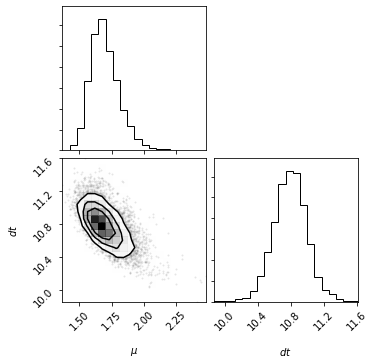

In [10]:
contour(fit2)

36 10 10 10
Mean of posterior: mu= 1.6990907668148765 dt= 10.790919335900108 

P's are calculated at t=  [  0.          15.54345814  31.08691628  46.63037442  62.17383256
  77.7172907   93.26074885 108.80420699 124.34766513 139.89112327]

 
chi^2--> r-band= 79.73360016868811 , g-band= 83.92866331795479 , i-band= 26.4504607926371
data points in r-band= 90 , g-band= 91 , i-band= 30


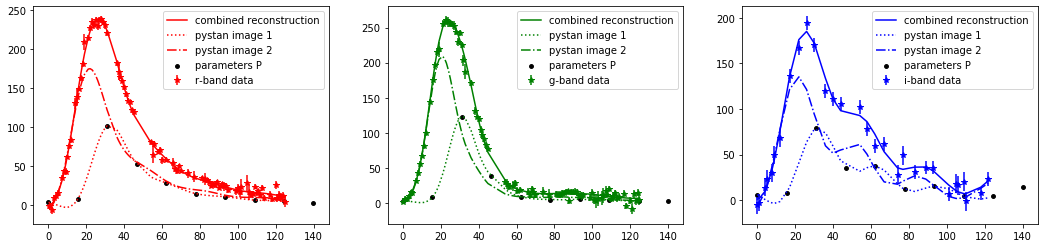

In [11]:
rec(fit2,10,10,10)

The overall $\chi^2$ is good. The constrained $\mu \approx 1.7 \pm 0.11$ is also nice. But the time delay ($dt \approx 10.8 \pm 0.2$) is much higher than expected. This is possibly because my parameters P are very much spread in time. Possibly we need higher NP. Look at the i-band. The reconstructed signal looks bad. Possibly we need fewer parameters for i-band.

Below we try with NP=15, same for all the bands.

In [12]:
NP=15;
dt_min=0.0; dt_max=15.0
#t_range=np.amax(t)-np.amin(t)
tp=np.linspace(t_min, t_max+dt_max, NP)
print("tp=",tp)
td=(t_max-t_min+dt_max-dt_min)/(NP-1); print("td=",td);
data = {'ni':NI,'NP':NP,
        'Nr': len(tr), 'Ng': len(tg), 'Ni': len(ti),'tr': tr, 'tg': tg, 'ti': ti,
        'yr': fr, 'yg': fg, 'yi': fi, 'yr_error':sigfr, 'yg_error':sigfg, 'yi_error':sigfi,
        'tp':tp,'td':td, 'dt_max':dt_max}

sm = pystan.StanModel(model_code=model)

fit3 = sm.sampling(data=data, iter=4000, chains=6, warmup=400, thin=3, seed=4201)#,control=dict(max_treedepth=15,adapt_delta=1.2))
print(fit3)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8c311571e3884dc0539471611f2ee76f NOW.


tp= [  0.           9.99222309  19.98444618  29.97666927  39.96889236
  49.96111545  59.95333854  69.94556163  79.93778472  89.93000782
  99.92223091 109.914454   119.90667709 129.89890018 139.89112327]
td= 9.992223090561831


Inference for Stan model: anon_model_8c311571e3884dc0539471611f2ee76f.
6 chains, each with iter=4000; warmup=400; thin=3; 
post-warmup draws per chain=1200, total post-warmup draws=7200.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Pr[1]    0.86    0.01    0.8   0.03   0.27   0.63    1.2   2.93   4083    1.0
Pr[2]   20.32    0.56   10.7   5.45  12.26  18.06  26.06  46.95    365   1.01
Pr[3]  139.96    0.48  10.77 120.89 131.25 139.43 149.14 159.43    509   1.01
Pr[4]  181.48    0.22   6.48 168.73  176.9 181.58 186.34 192.94    872   1.01
Pr[5]  120.72    0.14   4.33 112.36 117.66 120.77 124.03 128.34    919   1.01
Pr[6]   76.54    0.09   3.59  69.29  74.06  76.69  79.09  83.21   1548    1.0
Pr[7]   50.77    0.05   2.18  46.38  49.29  50.81  52.31  54.92   1663   1.01
Pr[8]   33.87    0.07   2.14  29.62  32.43  33.96  35.38  37.81    944    1.0
Pr[9]   27.84    0.04   2.19  23.49  26.36  27.86  29.35  32.09   2784    1.0
Pr[10]  19.11    0.04    1.6  15

Expected: mu= 1.7994609012648153 dt= 6.036739147275044


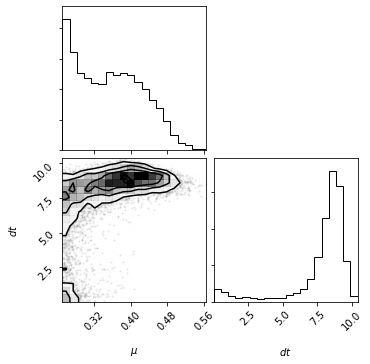

In [20]:
contour(fit3)

51 15 15 15
Mean of posterior: mu= 0.3548111350451528 dt= 7.780087545919987 

P's are calculated at t=  [  0.           9.99222309  19.98444618  29.97666927  39.96889236
  49.96111545  59.95333854  69.94556163  79.93778472  89.93000782
  99.92223091 109.914454   119.90667709 129.89890018 139.89112327]

 
chi^2--> r-band= 83.98816348192271 , g-band= 76.24361225126422 , i-band= 18.286220413951668
data points in r-band= 90 , g-band= 91 , i-band= 30


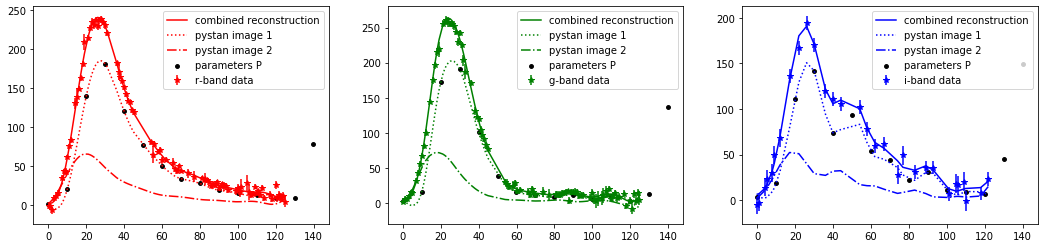

In [13]:
npn=15
rec(fit3, npn,npn,npn)

Again the overall fit is quite good. The time delay, $dt = 7.78 \pm 2.16$ is better now. But now the amplification ($\mu$) is too small (for a very small $\mu$, the time delay does not matter much). This is possibly because of more freedom to the first image. The i-band images are bad. Note that the fitting prefers smaller value of lg (smoothing in the kernel for the g-band) to fit the wiggles at the high t in g-band.

Below we try with NP=8, same for all the bands.

In [27]:
NP=8;
dt_min=0.0; dt_max=15.0
#t_range=np.amax(t)-np.amin(t)
tp=np.linspace(t_min, t_max+dt_max, NP)
print("tp=",tp)
td=(t_max-t_min+dt_max-dt_min)/(NP-1); print("td=",td);
data = {'ni':NI,'NP':NP,
        'Nr': len(tr), 'Ng': len(tg), 'Ni': len(ti),'tr': tr, 'tg': tg, 'ti': ti,
        'yr': fr, 'yg': fg, 'yi': fi, 'yr_error':sigfr, 'yg_error':sigfg, 'yi_error':sigfi,
        'tp':tp,'td':td, 'dt_max':dt_max}

sm = pystan.StanModel(model_code=model)

fit0 = sm.sampling(data=data, iter=4000, chains=6, warmup=400, thin=3, seed=4201)#,control=dict(max_treedepth=15,adapt_delta=1.2))
print(fit0)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8c311571e3884dc0539471611f2ee76f NOW.


tp= [  0.          19.98444618  39.96889236  59.95333854  79.93778472
  99.92223091 119.90667709 139.89112327]
td= 19.984446181123662


Inference for Stan model: anon_model_8c311571e3884dc0539471611f2ee76f.
6 chains, each with iter=4000; warmup=400; thin=3; 
post-warmup draws per chain=1200, total post-warmup draws=7200.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Pr[1]   0.04  6.7e-4   0.04 1.1e-3   0.01   0.03   0.05   0.14   3438    1.0
Pr[2] 146.51     0.4   3.84 137.35 144.67 147.43 149.23 151.23     92   1.05
Pr[3] 126.22    0.35   3.34 118.33 124.64 126.99  128.6 130.45     93   1.06
Pr[4]  45.08    0.12   1.45  41.89  44.29  45.23  46.06  47.47    146   1.04
Pr[5]  28.39     0.1   1.14  25.92  27.71  28.47  29.14  30.46    120   1.03
Pr[6]  12.62    0.03   1.09  10.55   11.9  12.61  13.36  14.79   1270    1.0
Pr[7]  12.03    0.04   1.17   9.72  11.25  12.03  12.81  14.39    864   1.01
Pr[8]   2.37    0.05   2.19   0.07   0.75   1.75   3.35   8.29   2160    1.0
Pg[1]   0.04  7.5e-4   0.04 1.0e-3   0.01   0.03   0.06   0.15   2853    1.0
Pg[2] 167.18    0.45   4.37 156.94 165.15 

Expected: mu= 1.7994609012648153 dt= 6.036739147275044


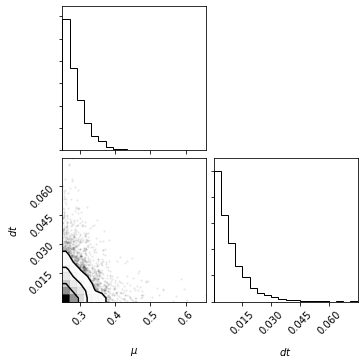

In [28]:
contour(fit0)

30 8 8 8
Mean of posterior: mu= 0.2863108638234407 dt= 0.008630791139219274 

P's are calculated at t=  [  0.          19.98444618  39.96889236  59.95333854  79.93778472
  99.92223091 119.90667709 139.89112327]

 
chi^2--> r-band= 1450.854131610297 , g-band= 1792.4983972442678 , i-band= 75.76502874512097
data points in r-band= 90 , g-band= 91 , i-band= 30


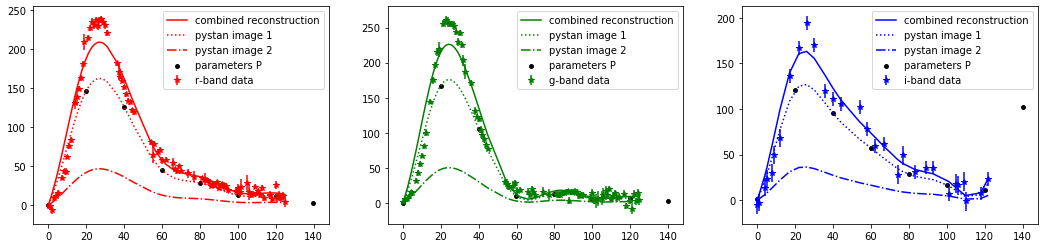

In [29]:
rec(fit0, 8,8,8)

The above fit is very bad, but at least the i-band images look a bit nicer!

Let us try with different number of parameters for different bands. NP=15 for red and green bands, while NP=8 for i-band.

In [16]:

model = """
functions{
    matrix kernel1(vector x0, vector x1, real l, int d){
        matrix [d,d] a;
        for (i in 1:d)
        {
            for (j in 1:i)
            {
                a[i][j]=exp(-0.5*(x0[i]-x1[j])*(x0[i]-x1[j])/(l*l));
                a[j][i]=a[i][j];
            }
            
        }
        return a;
    }
    
    matrix kernel2(vector x0, vector x1, real l, int d1, int d2){
        matrix [d1,d2] a;
        for (i in 1:d1)
        {
            for (j in 1:d2)
            {
                a[i][j]=exp(-0.5*(x0[i]-x1[j])*(x0[i]-x1[j])/(l*l));
            }
            
        }
        return a;
    }
    //================== calculating GP mean function =============================
    vector GP_mean(vector tp, vector t, vector P, real l, int NP, int N)
    {
        matrix[NP,NP] K;
        matrix[NP,NP] L;
        matrix[NP,N] Ks;
        matrix[NP,N] Lk;
        vector[NP] z;
        vector[N] m;
    
        K=kernel1(tp,tp,l, NP);       //NPxNP
        Ks=kernel2(tp,t,l, NP,N);       //NPxN
        L=cholesky_decompose(K); //NPxNP
        Lk=L\Ks;      //NPxN
        z=L\P;        //NP
        m=((Lk)')*z;// N
        return m;
    }
    //==============================================================================
}

data{

    int<lower=0> ni;
    
    int<lower=5> NPr;
    int<lower=5> NPg;
    int<lower=5> NPi;

    int<lower=0> Nr;
    int<lower=0> Ng;
    int<lower=0> Ni;

    vector[Nr] tr;
    vector[Nr] yr;
    vector[Nr] yr_error;

    vector[Ng] tg;
    vector[Ng] yg;
    vector[Ng] yg_error;

    vector[Ni] ti;
    vector[Ni] yi;
    vector[Ni] yi_error;


    vector[NPr] tpr;
    vector[NPg] tpg;
    vector[NPi] tpi;
    
    real dt_max;
}
parameters {
    vector <lower=0.0, upper=300.0> [NPr] Pr;
    vector <lower=0.0, upper=300.0> [NPg] Pg;
    vector <lower=0.0, upper=300.0> [NPi] Pi;
    
    
    real<lower=5.0, upper=30.0> lr;
    real<lower=5.0, upper=30.0> lg;
    real<lower=5.0, upper=30.0> li;
    
    real<lower=0.25, upper=4.0> mu;//actually measuring amplitudes relative 
    real <lower=0, upper=dt_max> dt;
    
    
    
    
}


model {
    vector[Nr] dumr;
    vector[Ng] dumg;
    vector[Ni] dumi;

    //dum needs GP
    dumr=GP_mean(tpr, tr, Pr, lr, NPr, Nr); //first image
    dumr=dumr+mu*GP_mean(tpr, tr+dt, Pr, lr, NPr, Nr); //adding the 2nd image
    target+=normal_lpdf(yr|dumr,yr_error);
    
    dumg=GP_mean(tpg, tg, Pg, lg, NPg, Ng); //first image
    dumg=dumg+mu*GP_mean(tpg, tg+dt, Pg, lg, NPg, Ng); //adding the 2nd image
    target+=normal_lpdf(yg|dumg,yg_error);
    
    dumi=GP_mean(tpi, ti, Pi, li, NPi, Ni); //first image
    dumi=dumi+mu*GP_mean(tpi, ti+dt, Pi, li, NPi, Ni); //adding the 2nd image
    target+=normal_lpdf(yi|dumi,yi_error);

}
"""
NI=2
NPr=14; NPg=14; NPi=8;# number of parameters is different for different bands
dt_min=0.0; dt_max=15.0
#now we calculate the time array for each band since the number of parameters can be different
tpr=np.linspace(t_min, t_max+dt_max, NPr); tpg=np.linspace(t_min, t_max+dt_max, NPg); 
tpi=np.linspace(t_min, t_max+dt_max, NPi); 
data = {'ni':NI,'NPr':NPr,'NPg':NPg,'NPi':NPi,
        'Nr': len(tr), 'Ng': len(tg), 'Ni': len(ti),'tr': tr, 'tg': tg, 'ti': ti,
        'yr': fr, 'yg': fg, 'yi': fi, 'yr_error':sigfr, 'yg_error':sigfg, 'yi_error':sigfi,
        'tpr':tpr,'tpg':tpg,'tpi':tpi, 'dt_max':dt_max}

sm = pystan.StanModel(model_code=model)

fit4 = sm.sampling(data=data, iter=5000, chains=4, warmup=400, thin=3, seed=301)#,control=dict(max_treedepth=15,adapt_delta=1.2))
print(fit4)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b7f142e8313be41d940e9dd70d8b09d3 NOW.


Inference for Stan model: anon_model_b7f142e8313be41d940e9dd70d8b09d3.
4 chains, each with iter=5000; warmup=400; thin=3; 
post-warmup draws per chain=1534, total post-warmup draws=6136.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Pr[1]     0.9    0.01   0.81   0.03    0.3   0.68   1.28   2.99   4653    1.0
Pr[2]   55.24    0.03   1.77  51.22  54.19  55.36  56.45  58.35   3215    1.0
Pr[3]  171.35    0.12   3.02 164.71 169.56 171.72 173.52 176.43    653    1.0
Pr[4]  168.29     0.1   2.89 162.11 166.46 168.64 170.39 173.12    915    1.0
Pr[5]  101.79    0.06   1.87  97.56 100.66 101.98 103.11 105.03    837    1.0
Pr[6]   65.46    0.04   1.77  62.01  64.24  65.46  66.67  68.94   1769    1.0
Pr[7]    40.9    0.03   1.36  38.32  39.96  40.89  41.85  43.62   2690    1.0
Pr[8]   31.46    0.03   1.74  28.07  30.28   31.4  32.61  34.91   4168    1.0
Pr[9]   22.18    0.01   0.94  20.37  21.55  22.16  22.79  24.04   4187    1.0
Pr[10]   16.7    0.02   1.37  14

Expected: mu= 1.7994609012648153 dt= 6.036739147275044


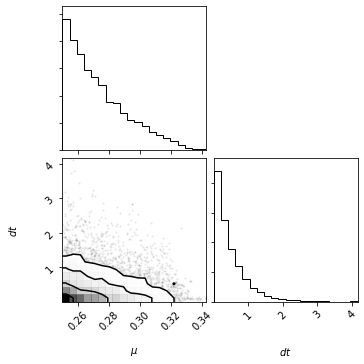

In [23]:
contour(fit4)

42 14 14 8
Mean of posterior: mu= 0.2734880241487216 dt= 0.47794779703077667 


 
chi^2--> r-band= 78.88277142613606 , g-band= 82.11584964295747 , i-band= 77.86793965842797
data points in r-band= 90 , g-band= 91 , i-band= 30


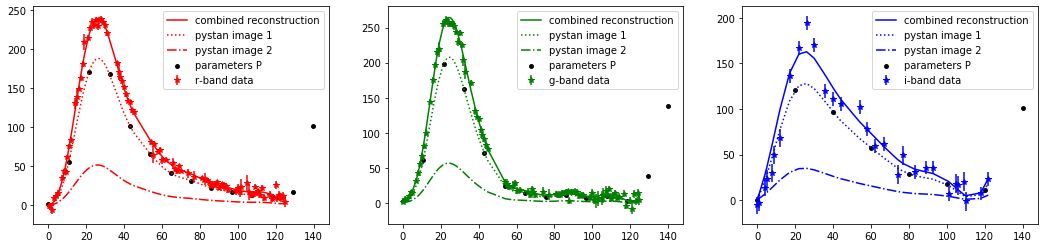

In [17]:
rec(fit4, NPr,NPg,NPi)

Results are bad. Both $\mu$ and $dt$ are very small. I am working on it. Note that the fitting prefers smaller value of lg (in the kernel) for the g-band to fit the wiggles at the higher t. 

Below, let us try with NP=15 for r and g bands, and NP=8 for the i-band.

In [18]:
NPr=15; NPg=15; NPi=8;# number of parameters is different for different bands
dt_min=0.0; dt_max=15.0
#now we calculate the time array for each band since the number of parameters can be different
tpr=np.linspace(t_min, t_max+dt_max, NPr); tpg=np.linspace(t_min, t_max+dt_max, NPg); 
tpi=np.linspace(t_min, t_max+dt_max, NPi); 
data = {'ni':NI,'NPr':NPr,'NPg':NPg,'NPi':NPi,
        'Nr': len(tr), 'Ng': len(tg), 'Ni': len(ti),'tr': tr, 'tg': tg, 'ti': ti,
        'yr': fr, 'yg': fg, 'yi': fi, 'yr_error':sigfr, 'yg_error':sigfg, 'yi_error':sigfi,
        'tpr':tpr,'tpg':tpg,'tpi':tpi, 'dt_max':dt_max}

sm = pystan.StanModel(model_code=model)

fit7 = sm.sampling(data=data, iter=5000, chains=4, warmup=400, thin=3, seed=301)#,control=dict(max_treedepth=15,adapt_delta=1.2))
print(fit7)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b7f142e8313be41d940e9dd70d8b09d3 NOW.


Inference for Stan model: anon_model_b7f142e8313be41d940e9dd70d8b09d3.
4 chains, each with iter=5000; warmup=400; thin=3; 
post-warmup draws per chain=1534, total post-warmup draws=6136.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Pr[1]    0.87    0.01   0.77   0.03   0.28   0.65   1.26   2.81   4553    1.0
Pr[2]   47.48    0.05   1.58  44.13  46.43  47.58  48.58  50.31   1033    1.0
Pr[3]  159.17    0.21   3.19 151.15 157.41 159.73 161.37 164.23    221   1.02
Pr[4]  179.65    0.24   3.43 171.17 177.79 180.31 182.15 184.71    207   1.02
Pr[5]  118.01    0.15   2.32  112.5 116.64 118.42 119.68 121.55    236   1.02
Pr[6]   75.83    0.11   2.36  70.94  74.32  75.92  77.45  80.29    490   1.01
Pr[7]   49.83    0.04   1.44  46.99  48.83  49.84   50.8  52.69   1542    1.0
Pr[8]   34.77    0.04   1.39  32.05   33.8  34.76   35.7  37.57   1210   1.01
Pr[9]   27.52    0.07   1.56  24.29  26.51  27.52   28.6  30.46    471   1.01
Pr[10]  19.49    0.02   0.99  17

Expected: mu= 1.7994609012648153 dt= 6.036739147275044


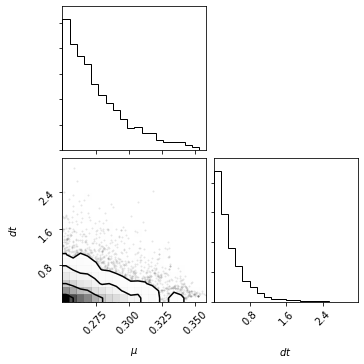

In [24]:
contour(fit7)

44 15 15 8
Mean of posterior: mu= 0.27628972702268795 dt= 0.34647175019041837 


 
chi^2--> r-band= 76.91141738186316 , g-band= 69.77320569285754 , i-band= 77.36982786818784
data points in r-band= 90 , g-band= 91 , i-band= 30


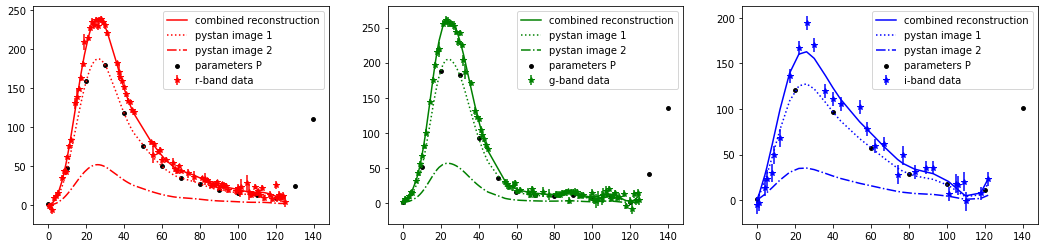

In [19]:
rec(fit7, NPr,NPg,NPi)

Similarly bad results.